In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import h5py, os

from msfm.utils import files, maps, power_spectra, parameters

24-01-05 09:24:38   imports.py INF   Setting up healpy to run on 8 CPUs 
24-01-05 09:24:39   imports.py INF   Setting up healpy to run on 8 CPUs 


In [3]:
conf_dir = "/cluster/home/athomsen/dlss/repos/multiprobe-simulation-forward-model/configs/v6/linear_bias.yaml"
conf = files.load_config(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

data_vec_pix, _, _, _ = files.load_pixel_file()

24-01-05 09:24:39     files.py INF   Loaded the pixel file /cluster/home/athomsen/dlss/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


# load data vector from .h5 file

In [4]:
# dv_file = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/linear_bias/grid/cosmo_000001/data_vectors_nobaryons.h5"
dv_file = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/linear_bias/fiducial/cosmo_fiducial/data_vectors_nobaryons.h5"

with h5py.File(dv_file, "r") as f:
    print(f.keys())
    
    kg = f["kg"][:10]
    ia = f["ia"][:10]
    sn = f["sn"][:10]
    
    dg = f["dg"][:10]

print(kg.shape)
print(ia.shape)
print(sn.shape)

n_z = 4

<KeysViewHDF5 ['dg', 'ia', 'kg', 'sn']>
(10, 464896, 4)
(10, 464896, 4)
(10, 3, 464896, 4)


# compute the power spectra

In [5]:
i_example = 0
i_noise = 0

hp_map = np.zeros((n_pix, n_z))

# hp_map[data_vec_pix] = kg[i_example]
# hp_map[data_vec_pix] = ia[i_example]
# hp_map[data_vec_pix] = sn[i_example, i_noise]
tomo_Aia_perts_dict = parameters.get_tomo_amplitude_perturbations_dict("Aia", conf)
# hp_map[data_vec_pix] = kg[i_example] + tomo_Aia_perts_dict["fiducial"] * ia[i_example]
hp_map[data_vec_pix] = kg[i_example] + tomo_Aia_perts_dict["fiducial"] * ia[i_example] + sn[i_example, i_noise]

# hp_map[data_vec_pix] = dg[i_example]

### with my functions (binning)

In [6]:
print("l_mins = ", conf["analysis"]["scale_cuts"]["lensing"]["l_min"])
print("l_maxs = ", conf["analysis"]["scale_cuts"]["lensing"]["l_max"])

l_mins =  [30, 30, 30, 30]
l_maxs =  [1535, 1535, 1535, 1535]


[Text(0.5, 0, 'summary dimension'), Text(0, 0.5, '$C_\\ell$'), None]

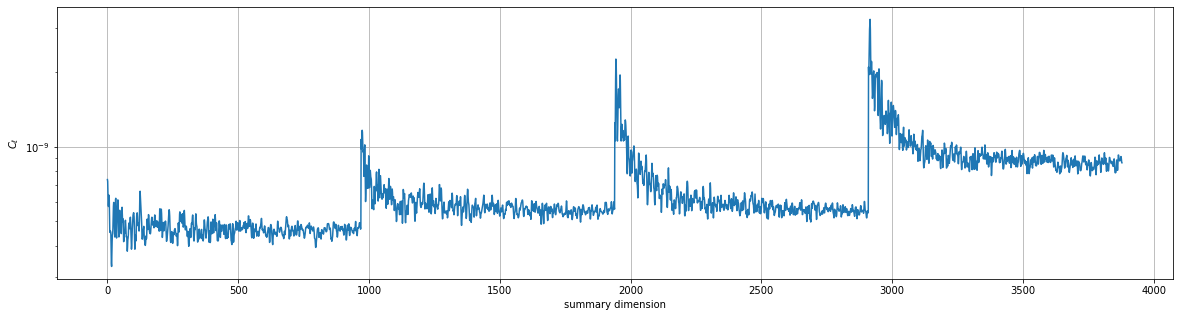

In [7]:
alm = power_spectra.get_alms(hp_map, nest=True)
cl = power_spectra.get_cls(
    alm,
    # l_mins=conf["analysis"]["scale_cuts"]["lensing"]["l_min"],
    # # + conf["analysis"]["scale_cuts"]["clustering"]["l_min"],
    # l_maxs=conf["analysis"]["scale_cuts"]["lensing"]["l_max"],
    # # + conf["analysis"]["scale_cuts"]["clustering"]["l_max"],
    # n_bins=conf["analysis"]["power_spectra"]["n_bins"],
    with_cross=False,
)[30:1000]

cl = np.concatenate([cl[...,i] for i in range(cl.shape[-1])], axis=-1)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(cl)
ax.grid(True)
# ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-12, 1e-8))
ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log")

### directly with healpy (no binning)

[Text(0.5, 0, 'summary dimension'), Text(0, 0.5, '$C_\\ell$'), None]

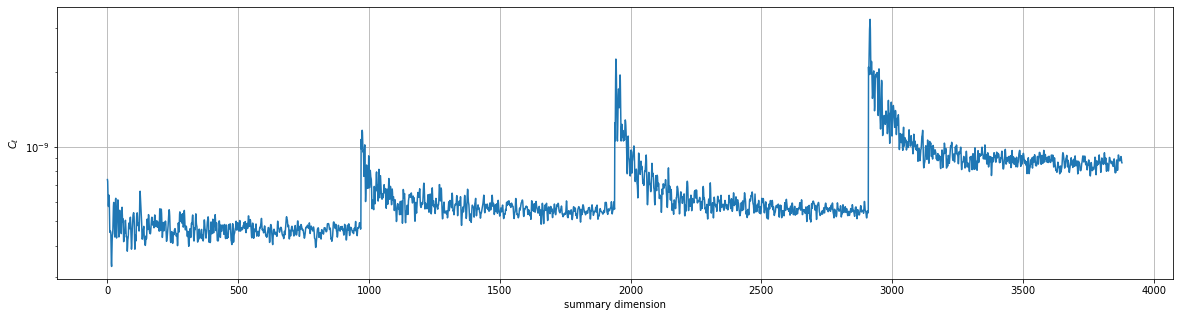

In [8]:
hp_map_ring = maps.tomographic_reorder(hp_map.copy(), n2r=True)

cl = []
for i in range(hp_map.shape[1]):
    for j in range(hp_map.shape[1]):
        # if i <= j:
        if i == j:
            cl_temp = hp.anafast(
                hp_map_ring[:,i],
                hp_map_ring[:,j],
                pol=False,
                use_pixel_weights=True
            )
            cl.append(cl_temp[30:1000])

cl = np.stack(cl, axis=-1)
cl = np.concatenate([cl[...,i] for i in range(cl.shape[-1])], axis=-1)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(cl)
ax.grid(True)
# ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-12, 1e-8))
ax.set(xlabel="summary dimension", ylabel=r"$C_\ell$", yscale="log")